In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)

from functions.model2 import GAN
import datetime
import json
from functions.data_preperation import process_model_data
from functions.q_generator import two_qubit_circuit_tickers

In [15]:
def shuffle_data(feature_data, real_data):
    # feature_data: numpy array
    # real_data: tf.Tensor

    # Make sure we have the same number of samples
    assert feature_data.shape[0] == real_data.shape[0], "Mismatched number of samples"

    # Generate shuffled indices
    indices = np.arange(feature_data.shape[0])
    np.random.shuffle(indices)

    # Apply to both
    feature_shuffled = feature_data[indices]
    real_shuffled = tf.gather(real_data, indices)

    return feature_shuffled, real_shuffled

In [16]:
DISCRIMINATOR_STEPS = 10
DISCRIMINATOR_LAYER_MULTIPLIER =2
GP_WEIGHT = 10
LEARNING_RATE = 1e-5
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
BATCH_SIZE = 32
EPOCHS = 100
D_OPTIMIZER = optimizers.Adam(learning_rate=LEARNING_RATE, beta_1 = ADAM_BETA_1, beta_2 = ADAM_BETA_2)
#G_OPTIMIZER = optimizers.Adam(learning_rate=LEARNING_RATE, beta_1 = ADAM_BETA_1, beta_2 = ADAM_BETA_2)

## Load data

In [17]:
targets = ["OC_next", "CO_next"]
features = ["Close", "High", "Low", "Open", "Volume", "MACD", "Signal_Line", "EMA_20"]
tickers = ['GOOG','AAPL','MSFT','AMZN']

In [18]:
train_data = process_model_data(targets, features, tickers) #feature_data, target_data

print(train_data)

/Users/a01milner/Documents/Schro-horse/functions/data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GOOG']: DNSError('Failed to perform, curl: (6) Could not resolve host: query2.finance.yahoo.com. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


/Users/a01milner/Documents/Schro-horse/functions/data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: DNSError('Failed to perform, curl: (6) Could not resolve host: query2.finance.yahoo.com. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
/Users/a01milner/Documents/Schro-horse/functions/data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MSFT']: DNSError('Failed to perform, curl: (6) Could not resolve host: query2.finance.yahoo.com. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
/Users/a01milner/Documents/Schro-horse/functio

(0,) (0,)
(array([], dtype=float64), <tf.Tensor: shape=(0,), dtype=float32, numpy=array([], dtype=float32)>)


## Load generator from Qiskit

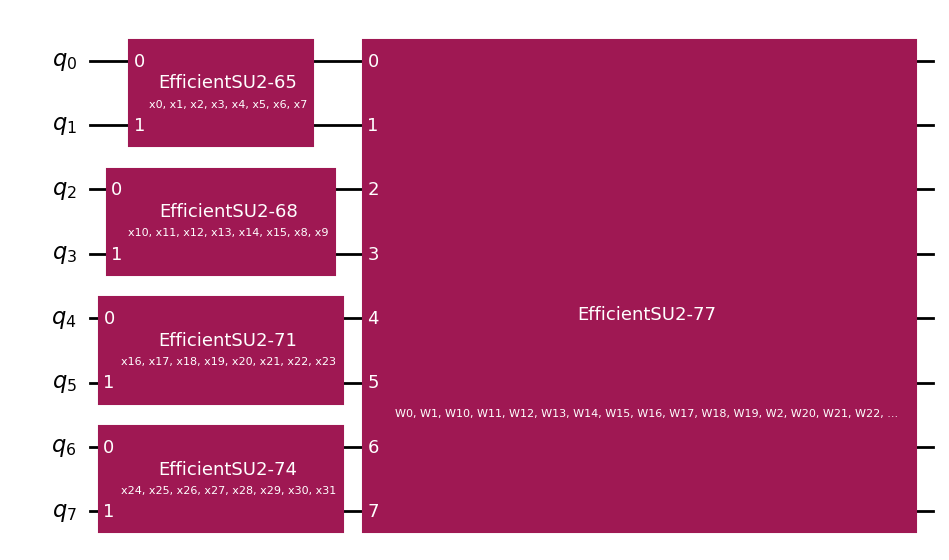

In [19]:
qc= two_qubit_circuit_tickers(tickers)
qc.draw('mpl')

In [20]:
qgan = GAN(
    discriminator_steps= DISCRIMINATOR_STEPS,
    gp_weight= GP_WEIGHT,
    n_tickers= len(tickers),
    n_features= len(features),
    n_outputs= len(targets),
    generator_qiskit=qc,
    discriminator_layer_multiplier=DISCRIMINATOR_LAYER_MULTIPLIER,
    on_hardware= False,
    batch_size= BATCH_SIZE,
)

qgan.compile(
    d_optimizer = D_OPTIMIZER,
    
)

Trial 2Q Depth: 8


/Users/a01milner/Documents/Schro-horse/.venv/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [21]:
#os.mkdir("models/")
time = datetime.datetime.now().strftime("%d%m.%H%M")
model_path = f"models/models_{time}"
os.mkdir(model_path)

In [22]:
import os
import numpy as np
import json
from tensorflow.keras.callbacks import Callback

class SaveWeightsAndMetrics(Callback):
    def __init__(self, qgan, save_dir="checkpoints", save_weights=True, save_metrics=True):
        super().__init__()
        self.qgan = qgan   # <-- store GAN object here
        self.save_dir = save_dir
        self.save_weights = save_weights
        self.save_metrics = save_metrics
        os.makedirs(save_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        # Save generator weights
        if self.save_weights:
            weights_path = os.path.join(self.save_dir, f"generator_weights_epoch{epoch+1}.npy")
            weights_list = [w.numpy() for w in self.qgan.generator_weights]
            np.save(weights_path, weights_list)
            print(f"✅ Saved generator weights to {weights_path}")

        # Save metrics
        if self.save_metrics:
            metrics_path = os.path.join(self.save_dir, f"metrics_epoch{epoch+1}.json")
            with open(metrics_path, "w") as f:
                json.dump({k: float(v) for k, v in logs.items()}, f, indent=2)
            print(f"📊 Saved metrics to {metrics_path}")


In [23]:
callbacks = [
    SaveWeightsAndMetrics(qgan=qgan, save_dir=f"{model_path}/logs")
]

In [24]:
feature_data, real_data = train_data
feature_data, real_data = shuffle_data(feature_data,real_data)

In [25]:
qgan.fit(
    feature_data=feature_data.astype(np.float32),
    real_data=real_data,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

ZeroDivisionError: float division by zero

In [ ]:
qgan.generator_save(f"{model_path}/generator.npy") 
qgan.discriminator.save(f"{model_path}/discriminator.keras")

Generator weights saved to models/models_3009.2002/generator.npy
